In [1]:
%pip install -q otter-grader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 12.5 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/kateyaknow/homeworke/

Cloning into 'homeworke'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 62 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 35.92 KiB | 3.59 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [7]:
%cd homeworke/decision_tress

/content/homeworke/decision_tress


In [8]:
# Initialize Otter
import otter
grader = otter.Notebook()

# **Домашнее задание 3.** Решающие деревья

В данном задании необходимо написать собственное решающее дерево.

In [9]:
from __future__ import annotations

from abc import abstractmethod
from dataclasses import dataclass
from typing import Literal, Optional, Self, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_friedman3, make_moons
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

---

### **Задание 1.** Меры неопределенности. Индекс Джини и энтропия

Для построения решающего дерева необходимо уметь оценивать неоднородность (impurity) в каждой вершине. При решении задачи классификации в качестве меры неоднородности можно использовать **индекс Джини** или **энтропию**:

- Индекс Джини:

  $$
  H_{\text{Gini}} = \sum_k p_k (1 - p_k)
  $$

- Энтропия:

  $$
  H_{\text{Entropy}} = - \sum_k p_k \log_2 p_k
  $$

Здесь $p_k$ — доля объектов класса $k$ в вершине.


_Points:_ 2

In [10]:
def gini(p: np.ndarray) -> float:
    """
    Args:
        p (np.ndarray): вектор вероятностей.

    Returns:
        float: значение индекса Джини.
    """
    return np.sum(p*(1-p))


def entropy(p: np.ndarray) -> float:
    """
    Args:
        p (np.ndarray): вектор вероятностей.

    Returns:
        float: значение энтропии.
    """
    return -1*np.sum(p*np.log2(p))

In [11]:
grader.check("Task1")

Task1 results: All test cases passed!

---

### **Задание 2.** Решающее дерево

Ниже реализован класс `Node`, представляющий одну вершину дерева. Атрибут `value` используется для хранения предсказаний в листовых вершинах. Остальные атрибуты нужны только для внутренних вершин:

- `feature` — индекс признака;  
- `threshold` — порог для разделения по данному признаку;  
- `lchild` — левая дочерняя вершина;  
- `rchild` — правая дочерняя вершина.

In [12]:
@dataclass
class Node:
    """Вершина решающего дерева."""

    value: Optional[Union[int, float]] = None
    feature: Optional[int] = None
    threshold: Optional[float] = None
    lchild: Optional[Node] = None
    rchild: Optional[Node] = None

Ознакомьтесь с классом `DecisionTreeModel`. Вам необходимо реализовать методы `_fit_node` и `_predict_node`. Обращайте внимание на подсказки в коде.

_Points:_ 5

In [17]:
class DecisionTreeModel:
    def __init__(self, max_depth: int = 5, min_leaf_size: int = 2) -> None:
        """
        Args:
            max_depth (int, optional): максимальная глубина дерева.
                Defaults to 5.
            min_leaf_size (int, optional): минимальное количество объектов в листе.
                Defaults to 2.
        """
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        self.root = Node()  # создаем корневой узел
        self._fit_node(self.root, X, y, 0)  # начинаем обучение
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = [self._predict_node(self.root, x) for x in X]
        return np.asarray(preds)

    def _fit_node(self, node: Node, X: np.ndarray, y: np.ndarray, depth: int) -> None:
        """Обучает узел.

        Args:
            node (Node): обучаемый узел.
            X (np.ndarray): объекты, матрица размера (?, d), где d - количество признаков.
            y (np.ndarray): целевые переменные, вектор размера (?,).
            depth (int): текущая глубина рекурсии.
        """
        # проверяем, не пора ли остановиться
        if depth >= self.max_depth or y.size <= self.min_leaf_size or np.all(y == y[0]):
            self._make_leaf(node, y)
            return  # завершаем обучение

        # здесь будем хранить лучшее разбиение
        best_feature, best_threshold, best_impurity = None, None, None

        n_features = X.shape[1]
        n_samples = y.shape[0]

        for feature in range(n_features):  # перебираем признаки
            # TODO: найдите уникальные значения данного признака
            unique = np.unique(X[:,feature])

            if unique.size <= 1:
                continue  # пропускаем признак, если все его значения одинаковые

            for threshold in unique[:-1]:  # перебираем пороги (уникальные значения)
                # TODO: разбейте целевые переменные на два подмножества (<= threshold)
                mask = X[:,feature]<=threshold

                yl = y[mask]
                yr = y[~mask]

                # если в одной из дочерних вершин оказалось недостаточно объектов, пропускаем разбиение
                if (yl.size < self.min_leaf_size) or (yr.size < self.min_leaf_size):
                    continue

                # TODO: используя метод `self._impurity`, рассчитайте меру неопределенности для разбиения:
                # |yl| / |y| x impurity(yl) + |yr| / |y| x impurity(yr) -> min
                # fmt: off
                impurity = len(yl)/len(y)*self._impurity(yl) + len(yr)/len(y)*self._impurity(yr)
                # fmt: on

                # сравниваем с лучшим разбиением и при необходимости обновляем его
                if (best_impurity is None) or (impurity < best_impurity):
                    best_feature, best_threshold, best_impurity = feature, threshold, impurity

        # если не удалось найти подходящее разбиение данных, завершаем обучение
        if best_feature is None or best_threshold is None:
            self._make_leaf(node, y)
            return  # завершаем обучение

        # TODO: обновите атрибуты обучаемого узла
        node.feature = best_feature
        node.threshold = best_threshold

        # TODO: разделите данные на два подмножества, используя лучшее разбиение
        mask = X[:, node.feature]<=node.threshold

        Xl, yl = X[mask], y[mask]
        Xr, yr = X[~mask], y[~mask]

        node.lchild = Node()  # создаем левую дочернюю вершину
        self._fit_node(node.lchild, Xl, yl, depth + 1)  # обучаем ее

        node.rchild = Node()  # создаем правую дочернюю вершину
        self._fit_node(node.rchild, Xr, yr, depth + 1)  # обучаем ее

    def _predict_node(self, node: Node, x: np.ndarray) -> Union[int, float]:
        """Делает предсказание для объекта или перенеправляет его в дочерний узел.

        Args:
            node (Node): узел.
            x (np.ndarray): объект.
        """
        # TODO: если узел листовой, верните его значение
        if node.lchild is None and node.rchild is None:
          return node.value

        # TODO: если узел внутренний, проверьте, в какой из его дочерних узлов следует перенаправить объект.
        # Затем верните предсказание для этого дочернего узла: `return self._predict_node(node.?child, x)`
        if x[node.feature]<=node.threshold:
          return self._predict_node(node.lchild,x)
        else:
          return self._predict_node(node.rchild,x)

    @abstractmethod
    def _make_leaf(self, node: Node, y: np.ndarray) -> None:
        pass  # необходимо реализовать в дочернем классе

    @abstractmethod
    def _impurity(self, y: np.ndarray) -> float:
        pass  # необходимо реализовать в дочернем классе

In [18]:
grader.check("Task2")

Task2 results: All test cases passed!

---

### **Задание 3.** Классификация

Теперь напишем класс `DecisionTreeClassifier`. К счастью, нам осталось реализовать только методы `_make_leaf` и `_impurity`. Оценивать модель будем на синтетических данных.



_Points:_ 3

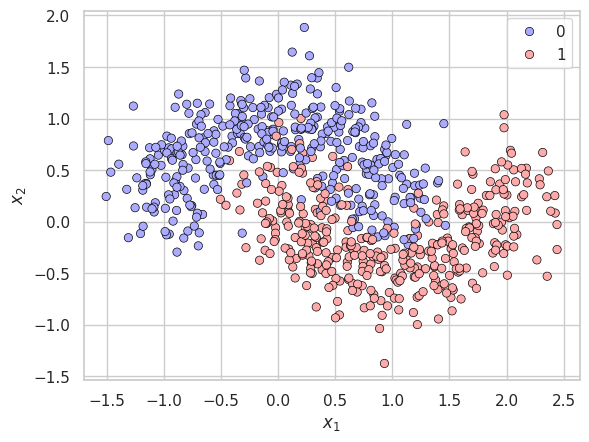

In [19]:
X, y = make_moons(n_samples=1_000, noise=0.25, random_state=451)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="bwr", edgecolor="black")
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.show()

In [20]:
class DecisionTreeClassifier(DecisionTreeModel):
    def __init__(
        self,
        max_depth: int = 5,
        min_leaf_size: int = 1,
        criterion: Literal["gini", "entropy"] = "gini",
    ) -> None:
        super().__init__(max_depth=max_depth, min_leaf_size=min_leaf_size)

        self.criterion = criterion

    def _make_leaf(self, node: Node, y: np.ndarray) -> None:
        # что является предсказанием решающего дерева в задаче классификации?
        values, counts = np.unique(y, return_counts=True)
        node.value = values[np.argmax(counts)]

    def _impurity(self, y: np.ndarray) -> float:
        # TODO: рассчитайте долю каждого класса среди целевых переменных
        _, counts = np.unique(y, return_counts=True)
        p = counts/np.sum(counts)

        if self.criterion == "gini":
            return gini(p)
        else:
            return entropy(p)

In [23]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [24]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Accuracy: 0.928


In [25]:
grader.check("Task3")

Task3 results: All test cases passed!

---

### **Задание 4.** Регрессия

Перейдем к задаче регрессии. Вам снова необходимо реализовать методы `_make_leaf` и `_impurity`, но с учётом новой постановки задачи.


_Points:_ 3

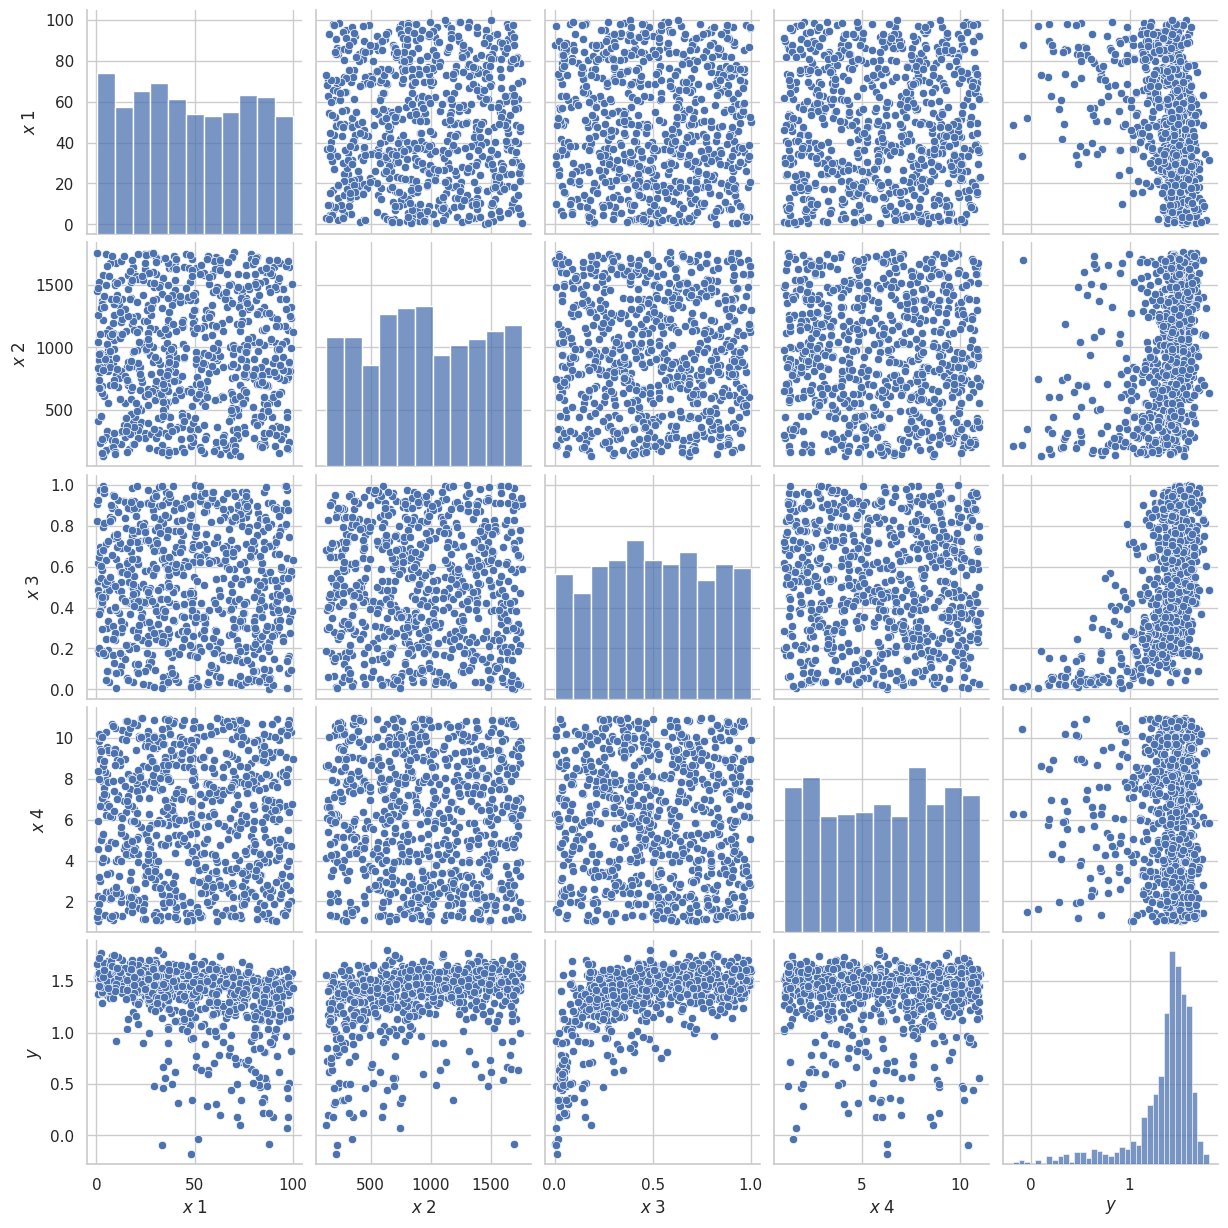

In [26]:
X, y = make_friedman3(n_samples=1_000, noise=0.1, random_state=451)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plot_data = pd.DataFrame(X_train, columns=[f"$ x_ {i}$" for i in range(1, 5)])
plot_data["$ y $"] = y_train
sns.pairplot(plot_data)

In [49]:
class DecisionTreeRegressor(DecisionTreeModel):
    def _make_leaf(self, node: Node, y: np.ndarray) -> None:
        # что является предсказанием решающего дерева в задаче регрессии?
        node.value = np.mean(y)

    def _impurity(self, y: np.ndarray) -> float:
        # что является мерой неоднородности в задаче регрессии?
        mse = np.mean(np.square(y-np.mean(y)))
        return mse

In [50]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

In [51]:
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

MAE: 0.116


In [52]:
grader.check("Task4")

Task4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)